# **Model Creation and Evaluation Notebook**

## Objectives
Answer business requirement 2:
The client is interested in predicting if a cherry leaf is healthy or contains powdery mildew.

## Inputs
* 'inputs/leaves_dataset/cherry-leaves/processed_images/test'
* 'inputs/leaves_dataset/cherry-leaves/processed_images/train'
* 'inputs/leaves_dataset/cherry-leaves/processed_images/validation'
* image shape embeddings.

## Outputs
* Machine learning model creation and training.
* Save model.
* Learning curve plot for model performance.
* Model evaluation on pickle file.
* Predictions on Test set of images 'not seen' before.

---

### Import Libraries

In [29]:
import os
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import sklearn
from matplotlib.image import imread
from tensorflow import keras
from keras.models import load_model
from keras.models import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D
from keras.callbacks import EarlyStopping
from keras.preprocessing import image
from keras._tf_keras.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_curve, auc

### Set Working Directory

In [2]:
current_dir = os.getcwd()
current_dir

'/workspaces/PP5-Cherry-Leaves/jupyter_notebooks'

In [3]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


In [4]:
current_dir = os.getcwd()
current_dir

'/workspaces/PP5-Cherry-Leaves'

---

Model packages used for this project are from keras and tensorflow specifically Sequential, Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D

Image Shapes Declaration

In [30]:
# Settings
file_path = '/workspaces/PP5-Cherry-Leaves/outputs'  # Same directory
file_prefix = 'image_shape'
file_extension = '.pkl'

# Get list of all matching pickle files
existing_files = [
    f for f in os.listdir(file_path)
    if f.startswith(file_prefix + '_') and f.endswith(file_extension)
]

if not existing_files:
    raise FileNotFoundError("❌ No image_shape pickle files found!")

# Sort files by number suffix (e.g., image_shape_1.pkl → 1)
existing_files.sort(key=lambda x: int(x[len(file_prefix) + 1:-len(file_extension)]))

# Load the most recent one
latest_file = existing_files[-1]
latest_path = os.path.join(file_path, latest_file)

with open(latest_path, 'rb') as f:
    image_shape = pickle.load(f)

print(f"✅ Loaded image shape from: {latest_path}")
print("Image shape:", image_shape)

✅ Loaded image shape from: /workspaces/PP5-Cherry-Leaves/outputs/image_shape_2.pkl
Image shape: (100, 100, 3)


Retrieving Class Indices

In [31]:
# Settings
file_path = '/workspaces/PP5-Cherry-Leaves/outputs'  # Same directory
file_prefix = 'class_indices'
file_extension = '.pkl'

# Get list of all matching pickle files
existing_files = [
    f for f in os.listdir(file_path)
    if f.startswith(file_prefix + '_') and f.endswith(file_extension)
]

if not existing_files:
    raise FileNotFoundError("❌ No class_indices pickle files found!")

# Sort files by number suffix (e.g., class_indices_1.pkl → 1)
existing_files.sort(key=lambda x: int(x[len(file_prefix) + 1:-len(file_extension)]))

# Load the most recent one
latest_file = existing_files[-1]
latest_path = os.path.join(file_path, latest_file)

with open(latest_path, 'rb') as f:
    class_indices = pickle.load(f)

print(f"✅ Loaded class indices from: {latest_path}")
print("Class Indices:", class_indices)

✅ Loaded class indices from: /workspaces/PP5-Cherry-Leaves/outputs/class_indices_2.pkl
Class Indices: {'healthy': 0, 'powdery_mildew': 1}


Model

In [32]:
def create_tf_model(image_shape=(100, 100, 3)):
    model = Sequential()

    # Define input shape only once at the beginning
    model.add(Input(shape=image_shape))

    model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    return model

Model Summary

In [33]:
create_tf_model().summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 98, 98, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 49, 49, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 47, 47, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 23, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 21, 21, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 6400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       819,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 875,777 (3.34 MB)

 Trainable params: 875,777 (3.34 MB)

 Non-trainable params: 0 (0.00 B)

Implementing Early Stopping

In [34]:
early_stop = EarlyStopping(monitor='val_loss', patience=3)

In [38]:
# Define the batch_size
batch_size = 10

# Define train and validation generators
train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)

train_set = train_datagen.flow_from_directory(
    '/workspaces/PP5-Cherry-Leaves/inputs/leaves_dataset/cherry-leaves/processed_images/train', 
    target_size=(100, 100), 
    batch_size=batch_size, 
    class_mode='binary'
)

validation_set = validation_datagen.flow_from_directory(
    '/workspaces/PP5-Cherry-Leaves/inputs/leaves_dataset/cherry-leaves/processed_images/validation', 
    target_size=(100, 100), 
    batch_size=batch_size, 
    class_mode='binary'
)

model = create_tf_model()
model.fit(train_set,
          epochs=25,
          steps_per_epoch=len(train_set.classes) // batch_size,
          validation_data=validation_set,
          callbacks=[early_stop],
          verbose=1
          )


# Train the model and capture the history object
history = model.fit(train_set,
                    epochs=25,
                    steps_per_epoch=len(train_set) // batch_size,
                    validation_data=validation_set,
                    validation_steps=len(validation_set) // batch_size,
                    callbacks=[early_stop],
                    verbose=1)

# Convert the history to a DataFrame
history_df = pd.DataFrame(history.history)

# Save the DataFrame to a CSV file
history_df.to_csv('outputs/training_history.csv', index=False)

Found 2944 images belonging to 2 classes.
Found 622 images belonging to 2 classes.
Epoch 1/25


/home/cistudent/.local/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


294/294 ━━━━━━━━━━━━━━━━━━━━ 24s 77ms/step - accuracy: 0.7754 - loss: 0.3905 - val_accuracy: 0.9968 - val_loss: 0.0198
Epoch 2/25
  1/294 ━━━━━━━━━━━━━━━━━━━━ 16s 57ms/step - accuracy: 1.0000 - loss: 6.3715e-04

/home/cistudent/.local/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


294/294 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 1.0000 - loss: 6.3715e-04 - val_accuracy: 0.9952 - val_loss: 0.0212
Epoch 3/25
294/294 ━━━━━━━━━━━━━━━━━━━━ 19s 66ms/step - accuracy: 0.9832 - loss: 0.0489 - val_accuracy: 0.9920 - val_loss: 0.0203
Epoch 4/25
294/294 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 1.0000 - loss: 0.0013 - val_accuracy: 0.9904 - val_loss: 0.0200
Epoch 1/25
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - accuracy: 0.9885 - loss: 0.0306 - val_accuracy: 0.9833 - val_loss: 0.0375
Epoch 2/25
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - accuracy: 0.9970 - loss: 0.0161 - val_accuracy: 0.9833 - val_loss: 0.0150
Epoch 3/25
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 86ms/step - accuracy: 0.9917 - loss: 0.0195 - val_accuracy: 1.0000 - val_loss: 0.0038
Epoch 4/25
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - accuracy: 0.9850 - loss: 0.0150 - val_accuracy: 0.9667 - val_loss: 0.0694
Epoch 5/25
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 87ms/step - accuracy: 1.0000 - loss: 0.0031 - val_accuracy: 1.0000 - val

OSError: Cannot save file into a non-existent directory: 'outputs'

Plots for training and validation loss as well as training and validation accuracy.

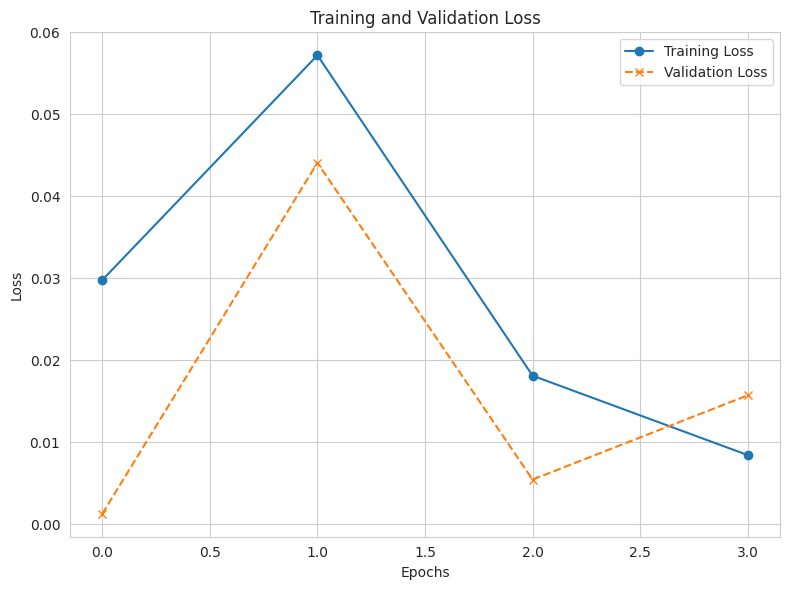

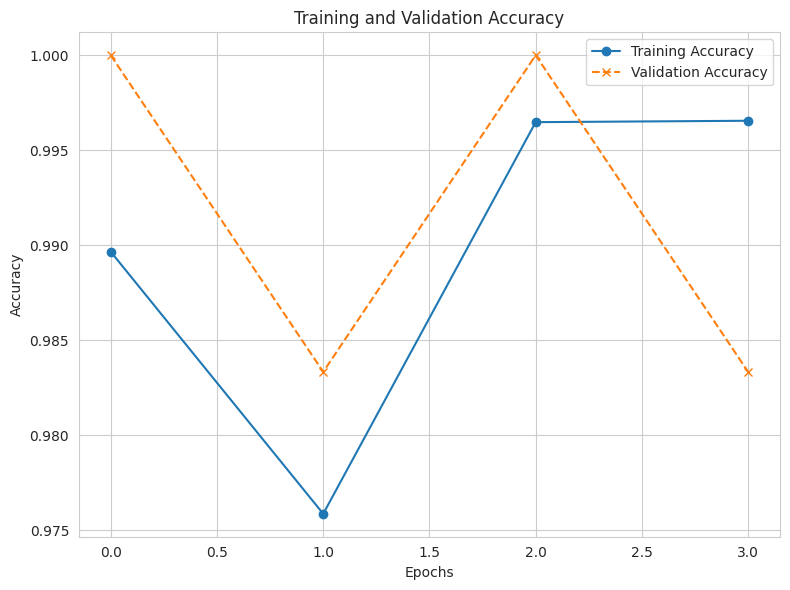

In [ ]:
# Create a new directory to save the plots, inside 'outputs'
plots_dir = 'outputs/training_plots'
os.makedirs(plots_dir, exist_ok=True)  # Create the directory if it doesn't exist

# Get the training history
history = model.history.history

# Plot 1: Loss vs. Validation Loss
plt.figure(figsize=(8, 6))
sns.set_style("whitegrid")
plt.plot(history['loss'], label='Training Loss', linestyle='-', marker='o')
plt.plot(history['val_loss'], label='Validation Loss', linestyle='--', marker='x')
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.tight_layout()
plt.savefig(f'{plots_dir}/model_training_loss.png', bbox_inches='tight', dpi=150)
plt.show()

# Plot 2: Accuracy vs. Validation Accuracy
plt.figure(figsize=(8, 6))
plt.plot(history['accuracy'], label='Training Accuracy', linestyle='-', marker='o')
plt.plot(history['val_accuracy'], label='Validation Accuracy', linestyle='--', marker='x')
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.tight_layout()
plt.savefig(f'{plots_dir}/model_training_accuracy.png', bbox_inches='tight', dpi=150)
plt.show()

Model Training

In [ ]:
model = load_model('outputs/cherry_leaf_model.h5')

In [ ]:
# Ensure that the model is compiled before fitting
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Now train the model
history = model.fit(train_set,
                    epochs=25,
                    steps_per_epoch=len(train_set) // batch_size,
                    validation_data=validation_set,
                    validation_steps=len(validation_set) // batch_size,
                    callbacks=[early_stop],
                    verbose=1)

# After training, you can access the metrics in the history object
history_df = pd.DataFrame(history.history)
history_df.to_csv('outputs/training_history.csv', index=False)

Epoch 1/25


29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 81ms/step - accuracy: 0.9982 - loss: 0.0095 - val_accuracy: 1.0000 - val_loss: 6.9871e-04
Epoch 2/25
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - accuracy: 0.9721 - loss: 0.1118 - val_accuracy: 0.9833 - val_loss: 0.0616
Epoch 3/25
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - accuracy: 0.9685 - loss: 0.2977 - val_accuracy: 1.0000 - val_loss: 0.0069
Epoch 4/25
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - accuracy: 0.9793 - loss: 0.0403 - val_accuracy: 1.0000 - val_loss: 0.0016


In [ ]:
# Evaluate the model on the validation data.
evaluation_metrics = model.evaluate(train_set)

# Output the evaluation result
print(f"Evaluation result: {evaluation_metrics}")

295/295 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - accuracy: 0.9994 - loss: 0.0054
Evaluation result: [0.006954987533390522, 0.9989809989929199]


In [ ]:
# Evaluate the model on the validation data.
evaluation_metrics = model.evaluate(validation_set)

# Output the evaluation result
print(f"Evaluation result: {evaluation_metrics}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9823 - loss: 0.0338
Evaluation result: [0.032738905400037766, 0.9871382713317871]


In [40]:
# Updated evaluation results
evaluation_results = {
    'Metric': ['Training Loss', 'Training Accuracy', 'Test Loss', 'Test Accuracy'],
    'Value': [0.0054, 0.9994, 0.0338, 0.9823]
}

# Convert to DataFrame
results_df = pd.DataFrame(evaluation_results)

# Save to CSV
results_df.to_csv('/workspaces/PP5-Cherry-Leaves/outputs/model_evaluation_results.csv', index=False)

# Print to verify
print(results_df)

              Metric   Value
0      Training Loss  0.0054
1  Training Accuracy  0.9994
2          Test Loss  0.0338
3      Test Accuracy  0.9823


---

Preparing model for analysis on testing dataset which the model has not 'seen'.

In [42]:
# Path to your main image folder
image_folder = "/workspaces/PP5-Cherry-Leaves/inputs/leaves_dataset/cherry-leaves/processed_images/test"  # Change this to your image folder path

# Initialize an empty list to store the images
test_set = []

# Iterate through each folder in the main folder (i.e., 'powdery_mildew', 'healthy')
for class_folder in os.listdir(image_folder):
    class_folder_path = os.path.join(image_folder, class_folder)

    # Skip if it's not a folder
    if os.path.isdir(class_folder_path):
        for filename in os.listdir(class_folder_path):
            img_path = os.path.join(class_folder_path, filename)

            # Make sure to skip non-image files (e.g., hidden files)
            if os.path.isfile(img_path):
                # Load and preprocess image
                img = image.load_img(img_path, target_size=(100, 100))
                img_array = image.img_to_array(img)  # Convert to numpy array
                test_set.append(img_array)

# Convert the list of images into a numpy array
test_set = np.array(test_set)

print("Shape of test_set:", test_set.shape)  # Should be (num_samples, 100, 100, 3)



Shape of test_set: (634, 100, 100, 3)


Generation of a confusion matrix and classification report

In [45]:
# Assuming `test_set` is already loaded with images (as you have confirmed)
# Initialize lists to collect true labels and predictions
all_preds = []
all_labels = []

batch_size = 10  # Example batch size, adjust as needed

# Define a mapping for labels
class_mapping = {"healthy": 0, "powdery_mildew": 1}

# Create labels for the test_set based on subfolders
test_labels = []

# Loop through each image in test_set and assign the correct label based on its folder
image_folder = "/workspaces/PP5-Cherry-Leaves/inputs/leaves_dataset/cherry-leaves/processed_images/test"  # Replace with your image folder path
for class_folder in os.listdir(image_folder):
    class_folder_path = os.path.join(image_folder, class_folder)
    if os.path.isdir(class_folder_path):
        label = class_mapping.get(class_folder, -1)  # Get label for class folder
        for filename in os.listdir(class_folder_path):
            img_path = os.path.join(class_folder_path, filename)
            if os.path.isfile(img_path):
                test_labels.append(label)

# Convert labels to numpy array (should match the number of images in test_set)
test_labels = np.array(test_labels)

# Loop through the test set in batches
for i in range(0, len(test_set), batch_size):
    # Get the current batch of images
    batch_X = test_set[i:i + batch_size]
    
    # Get the corresponding batch labels
    batch_y = test_labels[i:i + batch_size]

    # Make predictions for this batch
    raw_preds = model(batch_X)  # Get model predictions (raw output)
    preds = tf.cast(raw_preds >= 0.5, tf.int32).numpy()  # Convert to binary labels (0 or 1)

    # Collect predictions and true labels
    all_preds.extend(preds.flatten())
    all_labels.extend(batch_y.flatten())  # Ensure this matches your label shape

# Now compute the confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Print the confusion matrix
print("Confusion Matrix:\n", cm)

# Generate classification report (precision, recall, F1-score)
class_report = classification_report(all_labels, all_preds)
print("Classification Report:\n", class_report)

# Save classification report to TXT file
output_dir = "/workspaces/PP5-Cherry-Leaves/outputs"
with open(os.path.join(output_dir, "classification_report.txt"), "w") as f:
    f.write(class_report)

Confusion Matrix:
 [[316   1]
 [  1 316]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       317
           1       1.00      1.00      1.00       317

    accuracy                           1.00       634
   macro avg       1.00      1.00      1.00       634
weighted avg       1.00      1.00      1.00       634



A Confusion Matrix Plot showing True and False positives and negatives.

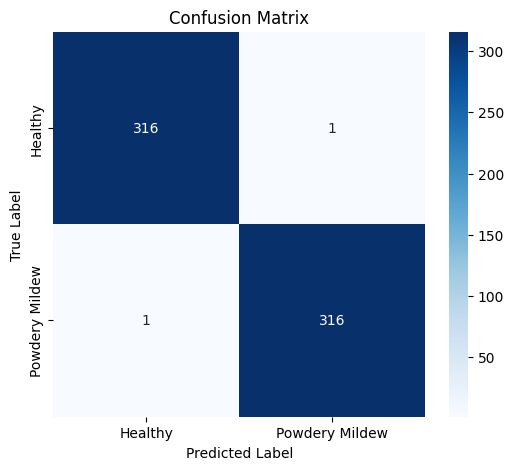

In [46]:
# Plotting the confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Create a heatmap for the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Healthy", "Powdery Mildew"], yticklabels=["Healthy", "Powdery Mildew"])

# Add labels and title
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')

# Show the plot
plt.show()

# Save confusion matrix as PNG
output_dir = "/workspaces/PP5-Cherry-Leaves/outputs"
os.makedirs(output_dir, exist_ok=True)  # Create the directory if it doesn't exist

plt.savefig(os.path.join(output_dir, "confusion_matrix.png"))
plt.close()

# Save confusion matrix as CSV
cm_df = pd.DataFrame(cm, index=["Healthy", "Powdery Mildew"], columns=["Healthy", "Powdery Mildew"])
cm_df.to_csv(os.path.join(output_dir, "confusion_matrix.csv"))


Preparing the data to generate a roc curve and AUC

In [47]:
# Load the CSV file containing image paths and labels
df = pd.read_csv('/workspaces/PP5-Cherry-Leaves/outputs/test_dataframe.csv')

X_test = []
y_test = []

# Load images and corresponding labels
for idx, row in df.iterrows():
    img_path = row['file']  # Assuming the column is named 'file'
    label = row['label']  # Assuming the column is named 'label'
    
    # Load and preprocess the image
    img = image.load_img(img_path, target_size=(100, 100))
    img_array = image.img_to_array(img) / 255.0  # Normalize image
    X_test.append(img_array)
    
    y_test.append(label)

# Convert lists to numpy arrays
X_test = np.array(X_test)
y_test = np.array(y_test)

Generating AUC and a ROC curve based on the Cherry Leaf Data.

In [48]:
# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Encode y_test to 0 and 1 (0: healthy, 1: powdery mildew)
y_test_encoded = label_encoder.fit_transform(y_test)  # This will convert 'healthy' to 0 and 'powdery_mildew' to 1

# Now you can compute the ROC curve
y_prob = model.predict(X_test)  # Predict probabilities for ROC/AUC

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_prob)  # Use the encoded y_test
roc_auc = auc(fpr, tpr)

# Print AUC
print(f"AUC: {roc_auc}")

20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step
AUC: 0.999512384440088


20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step
AUC: 0.9984


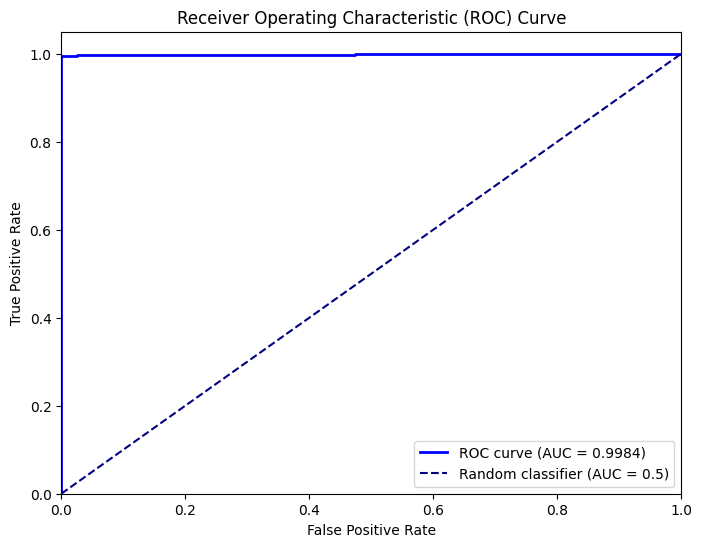

ROC curve saved to: /workspaces/PP5-Cherry-Leaves/outputs/training_plots/roc_curve.png


In [49]:
# Load the model
model = tf.keras.models.load_model('/workspaces/PP5-Cherry-Leaves/outputs/cherry_leaf_model.h5')

# Recompile the model
model.compile(optimizer='adam', 
              loss='binary_crossentropy',  # Assuming binary classification
              metrics=['accuracy', 'loss'])  # You can add more metrics if needed

# Assuming 'X_test' and 'y_test' are your test dataset and true labels
# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Encode y_test to 0 and 1 (0: healthy, 1: powdery mildew)
y_test_encoded = label_encoder.fit_transform(y_test)  # This will convert 'healthy' to 0 and 'powdery_mildew' to 1

# Predict probabilities for ROC/AUC
y_prob = model.predict(X_test)

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_prob)
roc_auc = auc(fpr, tpr)

# Print AUC
print(f"AUC: {roc_auc:.4f}")

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--', label='Random classifier (AUC = 0.5)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")

# Define the output directory
output_dir = '/workspaces/PP5-Cherry-Leaves/outputs/training_plots'

# Ensure the output directory exists
os.makedirs(output_dir, exist_ok=True)

# Save the ROC curve as a PNG file in the specified directory
roc_curve_path = os.path.join(output_dir, 'roc_curve.png')
plt.savefig(roc_curve_path)

# Optionally, you can also show the plot
plt.show()

# Print the file path where it is saved
print(f"ROC curve saved to: {roc_curve_path}")


Sample images showing predictions vs true values

Found 634 images belonging to 2 classes.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


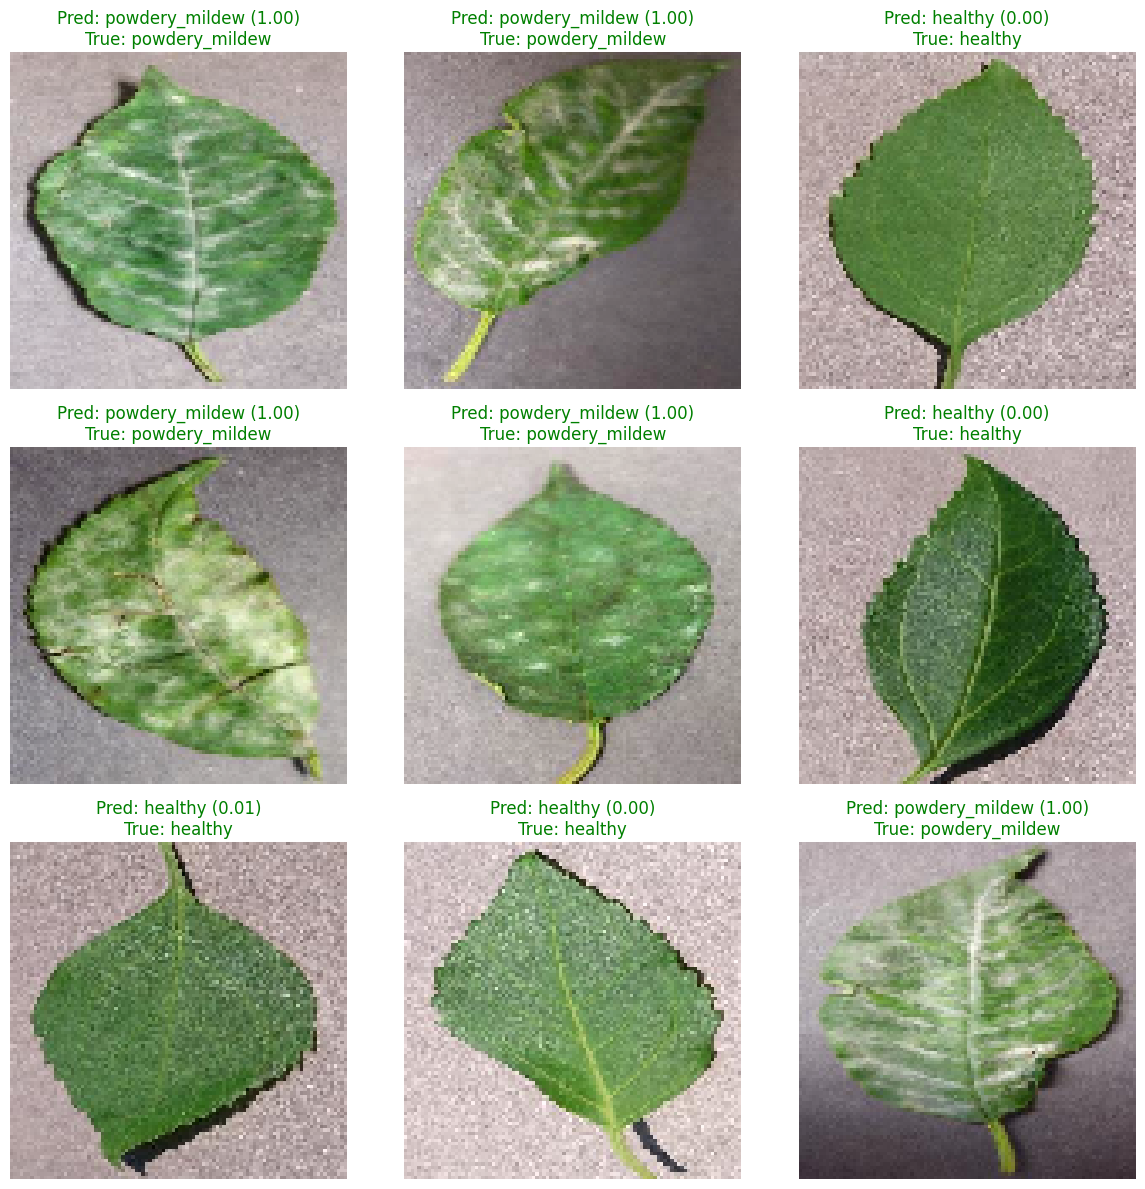

✅ Prediction image grid saved to: /workspaces/PP5-Cherry-Leaves/outputs
Saved to /workspaces/PP5-Cherry-Leaves/outputs/saved_results.csv


In [56]:
# === Load image shape from pickle ===
with open('/workspaces/PP5-Cherry-Leaves/outputs/image_shape_2.pkl', 'rb') as f:
    image_shape = pickle.load(f)[:2]

# === Rebuild test generator ===
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    directory='/workspaces/PP5-Cherry-Leaves/inputs/leaves_dataset/cherry-leaves/processed_images/test',
    target_size=image_shape,
    batch_size=32,
    class_mode='binary',
    shuffle=True
)

# === Get a batch and make predictions ===
sample_images, sample_labels = next(test_generator)
filenames = test_generator.filenames[:len(sample_images)]
predictions = model.predict(sample_images)
predicted_classes = np.round(predictions).astype(int).flatten()
confidences = predictions.flatten()

# === Get class label names ===
class_names = list(train_set.class_indices.keys())

# === Plot predictions ===
N = 9
plt.figure(figsize=(12, 12))

for i in range(N):
    plt.subplot(3, 3, i + 1)
    plt.imshow(sample_images[i])
    plt.axis('off')
    
    true_label = class_names[int(sample_labels[i])]
    predicted_label = class_names[predicted_classes[i]]
    conf = confidences[i]

    color = 'green' if predicted_label == true_label else 'red'
    plt.title(f"Pred: {predicted_label} ({conf:.2f})\nTrue: {true_label}", color=color)

plt.tight_layout()
save_path = "/workspaces/PP5-Cherry-Leaves/outputs"
plt.savefig(save_path)
plt.show()

print(f"✅ Prediction image grid saved to: {save_path}")

# === Save to CSV ===
csv_data = []

for i in range(len(sample_images)):
    csv_data.append({
        'File': filenames[i],
        'True Label': class_names[int(sample_labels[i])],
        'Predicted Label': class_names[predicted_classes[i]],
        'Confidence': round(confidences[i], 4)
    })

# Define output path
output_folder = "/workspaces/PP5-Cherry-Leaves/outputs"
os.makedirs(output_folder, exist_ok=True)  # Ensure folder exists

# Define full path to the CSV file
csv_path = os.path.join(output_folder, "saved_results.csv")

# Save the CSV
df.to_csv(csv_path, index=False)

print(f"Saved to {csv_path}")

Identifying Edge Cases

In [59]:
# === Save to CSV, sorted by confidence (ascending) ===
csv_data = []

for i in range(len(sample_images)):
    csv_data.append({
        'File': filenames[i],
        'True Label': class_names[int(sample_labels[i])],
        'Predicted Label': class_names[predicted_classes[i]],
        'Confidence': round(confidences[i], 4)
    })

csv_df = pd.DataFrame(csv_data)

# Sort by confidence: lowest to highest
csv_df_sorted = csv_df.sort_values(by='Confidence', ascending=True)

# Define directory and filename
output_dir = '/workspaces/PP5-Cherry-Leaves/outputs/saved_results'
os.makedirs(output_dir, exist_ok=True)  # Make sure the folder exists

csv_path = os.path.join(output_dir, 'saved_results.csv')
csv_df_sorted.to_csv(csv_path, index=False)

print(f"✅ Sorted CSV with edge-case insights saved to: {csv_path}")


✅ Sorted CSV with edge-case insights saved to: /workspaces/PP5-Cherry-Leaves/outputs/saved_results/saved_results.csv


---

outputs directory clean up

In [62]:
# Define paths
base_dir = "/workspaces/PP5-Cherry-Leaves"
outputs_dir = os.path.join(base_dir, "outputs")
figures_dir = os.path.join(outputs_dir, "figures")

# Create figures folder if it doesn't exist
os.makedirs(figures_dir, exist_ok=True)

# Move all .png files
for file in os.listdir(outputs_dir):
    if file.endswith(".png"):
        src = os.path.join(outputs_dir, file)
        dst = os.path.join(figures_dir, file)
        shutil.move(src, dst)
        print(f"✅ Moved: {file}")

print("🎉 All PNGs moved to outputs/figures/")

✅ Moved: avg_diff.png
✅ Moved: avg_var_powdery_mildew.png
✅ Moved: sample_predictions.png
✅ Moved: labels_distribution.png
✅ Moved: confusion_matrix.png
✅ Moved: avg_var_healthy.png
🎉 All PNGs moved to outputs/figures/
